In [17]:
import logging
import os
import jieba.posseg as psg
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from sklearn import preprocessing
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import glob
import pandas as pd
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel

def loadStops(filename):
    stops = []
    with open(filename, encoding='utf-8') as fr:
        fr.readline()
        for line in fr:
            stops.append(line.strip())
    return stops



def goTrainLDA(data,n_topic=10):

    dct = Dictionary(data)
    joblib.dump(dct, f'./models/dct{n_topic}.m')
    print('词库保存完毕！')
    corpus = [dct.doc2bow(_) for _ in data]
    print(len(dct))
#     ldamodel = LdaModel(corpus=corpus, num_topics=n_topic, id2word=dct,eta=0.0001,passes=10,random_state=100)
#     joblib.dump(ldamodel, f'./models/lda_model{n_topic}.m')
    print('LDA模型保存完毕！')


class LoadModel:
    def __init__(self,n_topic):
        self.ldamodel = joblib.load(f'./models/lda_model{n_topic}.m')
        self.dct = joblib.load(f'./models/dct{n_topic}.m')

    def batchPredict(self,data):
            #Print the 8 topic and largest weighted words in topic
#             topic_list=self.ldamodel.print_topics(8, 30)
            for topic in self.ldamodel.print_topics(20, 40):
                print(topic)
            
            for line in data:
                corpus = [self.dct.doc2bow(_) for _ in data]
                doc_lda = self.ldamodel[corpus[0]] 
                doc_lda_max = sorted(doc_lda, key=lambda k: k[1], reverse=True)[0]
                info = self.ldamodel.print_topic(doc_lda_max[0], 6)
                
                

                feather = [x.strip().replace('"', '').split('*') for x in info.strip().split('+')]
                weight_feather = [float(y[0]) for y in feather]
                word = [y[1] for y in feather]
#                 print("context:",line)
#                 print('LDA:', info)
#                 print('word:', word)
#                 print('weights:', weight_feather)
                self.ldamodel.print_topics(8, 30)
                break

    def topic_analysie(self,data):
            da = [self.dct.doc2bow(_) for _ in data]
            doc_lda = self.ldamodel[da]
            doc_lda_max = [sorted(w, key=lambda k: k[1], reverse=True)[0] for w in doc_lda]
            topic_list=[w for w,t in doc_lda_max]

            return topic_list

In [3]:
os.getcwd()

'C:\\Users\\sama\\Desktop\\NLP\\Project'

In [3]:

 
# Preprocesssing

filenames = glob.glob(r"stopwords/*")
stopwords = []
for filename in filenames:
    stopwords.extend(loadStops(filename))
    
filenames1 = glob.glob(r"lib/*")
lib = []
for filename in filenames1:
    lib.extend(loadStops(filename))    

temp = pd.read_csv(r"news_LABEL.csv", encoding="utf-8")

In [4]:
temp["context"]=temp.topic.str.cat(temp.title1.str.cat(temp.title2.str.cat(temp.content,na_rep=""),na_rep=""),na_rep="")
data = []
for line in temp.context:
    data.append(str(line).split())
temp.drop(temp.columns[[0,3,4,5,6,7,8]],axis=1,inplace=True)

In [5]:
temp.set_index(temp["日期"],drop=True,inplace=True)

In [6]:
temp.head()

,label,日期,context
日期,,,
2010/1/5,1,2010/1/5,2009年：广东大建设一路高歌2009年，对于广东的经济来说，是进入新世纪以来最为困难的一...
2010/1/5,1,2010/1/5,"要闻 2010年,在机遇与挑战的路上迅跑广东建设报记者畅谈新年前景新年伊始，万象更新。新的一..."
2010/1/5,1,2010/1/5,聚焦 东湖街垃圾分类做得出色2009年12月16日上午，广州城管委今年最后一次城管开放日活动...
2010/1/5,0,2010/1/5,建筑 广州1080座桥梁安全可控有关部门近日向社会透露——截至2008年底，广州市城区共有桥...
2010/1/5,0,2010/1/5,地产 广州今年供应近5万套保障房帮助更多低收入家庭解住房之忧“我们初步计划明年新开工建设保障...


In [7]:
filenames2 = glob.glob(r"envir_lib/*")
envir_words = []
import jieba
import re
for filename in filenames2:
    envir_words.extend(loadStops(filename)) 

stopwords.extend(["年","月","日","新","时","说"])    
for x in envir_words:
    jieba.add_word(x)
for x in lib:
    jieba.add_word(x)    
    
def cut_words(intxt):

    return " ".join([w for w in jieba.cut(re.sub(r'[0-9]+',"",str(intxt))) if w not in stopwords])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\sama\AppData\Local\Temp\jieba.cache
Loading model cost 0.684 seconds.
Prefix dict has been built successfully.


In [8]:
temp["cut"]= temp.context.apply(cut_words)

In [9]:
temp.to_csv("news_cut_lda.csv",encoding="utf-8")

# You can run the following code to get temp from news_cut_lda.csv 

In [23]:
temp=pd.read_csv("news_cut_lda.csv",encoding="utf-8")

In [24]:
temp.set_index(["日期"],drop=True,inplace=True)

In [25]:
stopwords_tan = loadStops(r"stop.txt")
print(stopwords_tan)

['去年', '提出', '屋顶', '约', '号', '广东建设报', '科技报', '经济报', '全市', '绿色', '碳', '增长', '.%', '广东', '广州', '领域', '国家', '广东省', '珠三角', '项目', '加快', '区', '提高', '顺德', '高', '纯', '家', '关注', '…', '学会', '国内', '东莞', '深圳', '佛山', '海珠区', '湛江', '大鹏', '省', '占', '地区', '达', '珠海', '全省', '中心', '提升', '升级', '惠州', '肇庆', '我省', '格力', '低', '我国', '提供']


In [26]:
stopwords_tan.extend(["村","中","推动","工作","相关","更","推进","广东","发展","%","建设","城市","权","镇","寨说","南方日报","记者"])
def refine(intxt):
    return " ".join([w for w in str(intxt).split() if w not in stopwords_tan])

In [27]:
tan=pd.DataFrame([[2010,2.497946263],
[2011,2.406106919],
[2012,3.571845513],
[2013,4.302691177],
[2014,4.037716008],
[2015,4.552173336],
[2016,3.366226293],
[2017,2.528045957]
],columns=["date","vol"])
tan.set_index(["date"],inplace=True)

In [28]:
def cor(n_topic,corpus,df,df_index):
    print(f"=============={n_topic}===============")
    df_index.set_index(pd.to_datetime(df_index.index),inplace=True)
    df_env=pd.DataFrame(index=pd.to_datetime(df.index))
    lm = LoadModel(n_topic)
    lm.batchPredict(corpus)
    topic_list=lm.topic_analysie(corpus)
    df_env["topic"]=np.array(topic_list)
    print(df_env.topic)
#     count=df_env.groupby(df_env.index.year)["topic"].count()
    count=df_index.groupby(df_index.index.year)["cut"].count()
    print(count)
    group=df_env.groupby([df_env.index.year,"topic"])["topic"].count()/count
    group=group.unstack(level=0)
    print(group)
    print(f"==============corr===============")
    print(group.corrwith(tan.vol,axis=1))

# LDA for envirenment content (7420)

In [29]:
df_env=temp[temp.label==1]
print(f"df_env{df_env.shape}")

df_env(7420, 4)


# LDA for envirenment content contains("碳|减排|节能") (2375)

In [11]:
stopwords_tan

['去年',
 '提出',
 '屋顶',
 '约',
 '号',
 '广东建设报',
 '科技报',
 '经济报',
 '全市',
 '绿色',
 '碳',
 '增长',
 '.%',
 '广东',
 '广州',
 '领域',
 '国家',
 '广东省',
 '珠三角',
 '项目',
 '加快',
 '区',
 '提高',
 '顺德',
 '高',
 '纯',
 '家',
 '关注',
 '…',
 '学会',
 '国内',
 '东莞',
 '深圳',
 '佛山',
 '海珠区',
 '湛江',
 '大鹏',
 '省',
 '占',
 '地区',
 '达',
 '珠海',
 '全省',
 '中心',
 '提升',
 '升级',
 '惠州',
 '肇庆',
 '我省',
 '格力',
 '低',
 '我国',
 '提供',
 '村',
 '中',
 '推动',
 '工作',
 '相关',
 '更',
 '推进',
 '广东',
 '发展',
 '%',
 '建设',
 '城市',
 '权',
 '镇',
 '寨说',
 '南方日报',
 '记者']

In [12]:
df_env_contain1=df_env[df_env['context'].str.contains("碳|减排|节能")]
print(f"df_env_contain1{df_env_contain1.shape}")

df_env_contain1(2375, 4)


In [30]:
corpus = []
for line in df_env_contain1.cut:
            corpus.append([w for w in str(line).split() if w not in stopwords_tan])

In [31]:
#训练LDA 模型，并保存
for i in range(1,11):
    goTrainLDA(corpus,i)

词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！
词库保存完毕！
148943
LDA模型保存完毕！


In [136]:
x_list = []
y_list = []
for i in range(1,11):
    lm = LoadModel(i)
    dct = Dictionary(corpus)
    data = [dct.doc2bow(_) for _ in corpus]
    perplexity = lm.ldamodel.log_perplexity(data)
    print(perplexity)
    x_list.append(i)
    y_list.append(perplexity)
    
    

-366.1365620174658
-373.4979706257258
-387.5208899917782
-408.90322501044585
-423.59825933655594
-436.96536956023255
-447.4147996352857
-460.1255202612651
-470.5277235494258
-480.6817544449852


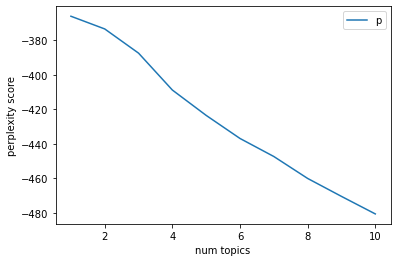

In [137]:
plt.plot(x_list, y_list)
plt.xlabel('num topics')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')
plt.show()   

In [138]:
x1_list = []
y1_list = []
for i in range(1,11):
    lm = LoadModel(i)
    dct = Dictionary(corpus)
    data = [dct.doc2bow(_) for _ in corpus]
    cv_tmp = CoherenceModel(model=lm.ldamodel, texts=corpus, dictionary=dct, coherence='c_v')
    x1_list.append(i)
    y1_list.append(cv_tmp.get_coherence())

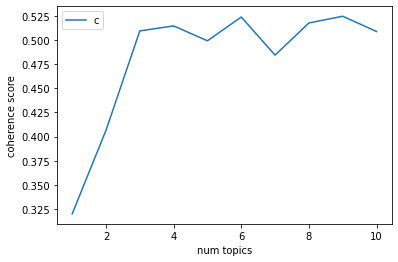

In [139]:
plt.plot(x1_list, y1_list)
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [135]:
for i in range(4,11):
    cor(i,corpus,df_env_contain1,df_env_contain1)

==============4===============
(0, '0.019*"企业" + 0.019*"产业" + 0.013*"创新" + 0.007*"合作" + 0.006*"经济" + 0.006*"市场" + 0.006*"中国" + 0.006*"亿元" + 0.006*"技术" + 0.005*"产品" + 0.005*"投资" + 0.005*"装备" + 0.005*"国际" + 0.005*"科技" + 0.005*"低碳" + 0.004*"新能源" + 0.004*"制造" + 0.004*"LED" + 0.004*"全国" + 0.004*"转型" + 0.004*"智能" + 0.004*"研发" + 0.004*"生产" + 0.004*"战略" + 0.004*"行业" + 0.004*"平台" + 0.004*"照明" + 0.003*"先进" + 0.003*"汽车" + 0.003*"公司" + 0.003*"能源" + 0.003*"制造业" + 0.003*"基地" + 0.003*"全球" + 0.003*"服务" + 0.003*"政策" + 0.003*"重点" + 0.002*"园区" + 0.002*"支持" + 0.002*"金融"')
(1, '0.012*"环保" + 0.008*"生态文明" + 0.008*"环境" + 0.006*"污染" + 0.006*"实施" + 0.005*"治理" + 0.005*"制度" + 0.005*"重点" + 0.005*"企业" + 0.005*"目标" + 0.004*"空气质量" + 0.004*"生态" + 0.004*"全国" + 0.004*"整治" + 0.004*"环境保护" + 0.003*"厅" + 0.003*"排放" + 0.003*"考核" + 0.003*"管理" + 0.003*"减排" + 0.003*"机制" + 0.003*"经济" + 0.003*"PM" + 0.003*"区域" + 0.003*"政府" + 0.003*"生态环境" + 0.003*"市" + 0.003*"情况" + 0.003*"建立" + 0.003*"落实" + 0.003*"方案" + 0.003*"社会" + 0.003*"达标" + 0

日期
2010-01-05    3
2010-01-05    3
2010-01-05    2
2010-01-12    0
2010-01-15    2
             ..
2017-12-12    5
2017-12-15    1
2017-12-20    4
2017-12-26    0
2017-12-29    1
Name: topic, Length: 2375, dtype: int32
日期
2010    442
2011    383
2012    422
2013    339
2014    190
2015    232
2016    196
2017    171
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.253394  0.216710  0.187204  0.168142  0.105263  0.211207  0.132653   
1      0.072398  0.109661  0.113744  0.162242  0.231579  0.181034  0.198980   
2      0.368778  0.355091  0.343602  0.303835  0.310526  0.241379  0.214286   
3      0.122172  0.101828  0.106635  0.079646  0.073684  0.094828  0.076531   
4      0.085973  0.096606  0.082938  0.064897  0.094737  0.073276  0.117347   
5      0.097285  0.120104  0.165877  0.221239  0.184211  0.198276  0.260204   

日期         2017  
topic  

日期
2010-01-05    0
2010-01-05    3
2010-01-05    6
2010-01-12    7
2010-01-15    6
             ..
2017-12-12    1
2017-12-15    1
2017-12-20    6
2017-12-26    0
2017-12-29    1
Name: topic, Length: 2375, dtype: int32
日期
2010    442
2011    383
2012    422
2013    339
2014    190
2015    232
2016    196
2017    171
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.201357  0.187990  0.168246  0.176991  0.147368  0.198276  0.117347   
1      0.061086  0.093995  0.090047  0.135693  0.200000  0.172414  0.178571   
2      0.138009  0.180157  0.151659  0.138643  0.089474  0.181034  0.173469   
3      0.144796  0.086162  0.073460  0.050147  0.052632  0.064655  0.091837   
4      0.036199  0.060052  0.054502  0.038348  0.052632  0.043103  0.076531   
5      0.047511  0.057441  0.097156  0.091445  0.110526  0.073276  0.086735   
6      0.128959  0.138381 

日期
2010-01-05    3
2010-01-05    3
2010-01-05    6
2010-01-12    7
2010-01-15    6
             ..
2017-12-12    5
2017-12-15    8
2017-12-20    6
2017-12-26    0
2017-12-29    1
Name: topic, Length: 2375, dtype: int32
日期
2010    442
2011    383
2012    422
2013    339
2014    190
2015    232
2016    196
2017    171
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.196833  0.195822  0.154028  0.156342  0.136842  0.185345  0.091837   
1      0.045249  0.065274  0.075829  0.123894  0.131579  0.094828  0.147959   
2      0.135747  0.177546  0.142180  0.109145  0.073684  0.142241  0.107143   
3      0.149321  0.101828  0.071090  0.056047  0.052632  0.051724  0.061224   
4      0.038462  0.054830  0.066351  0.035398  0.047368  0.038793  0.071429   
5      0.031674  0.041775  0.085308  0.064897  0.052632  0.064655  0.045918   
6      0.106335  0.104439 

# LDA for all content contains("碳|减排|节能") (5081)

In [19]:
temp.dropna(axis=0,inplace=True)

In [20]:
df_temp_contain1=temp[temp['context'].str.contains("碳|减排|节能")]
print(f"df_temp_contain1{df_temp_contain1.shape}")

df_temp_contain1(5081, 4)


In [21]:
corpus = []
for line in df_temp_contain1.cut:
            corpus.append([w for w in str(line).split() if w not in stopwords_tan])

In [22]:
#训练LDA 模型，并保存
for i in range(11,21):
    goTrainLDA(corpus,i)

词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！
词库保存完毕！
115825
LDA模型保存完毕！


KeyboardInterrupt: 

-413.23614053365355
-428.3964850731341
-440.19428784017634
-446.9916574768079
-453.34823404753
-461.5862216375042
-463.28477307924425
-467.2572701821618
-471.32168352926453
-475.8033945051796
-477.35025412754567
-481.52901463600955
-484.0673648133223
-485.5775043286006
-488.5020629150067
-492.17622333405467
-496.0508625685916
-497.418343518025
-500.5644796341063
-501.39628600601316


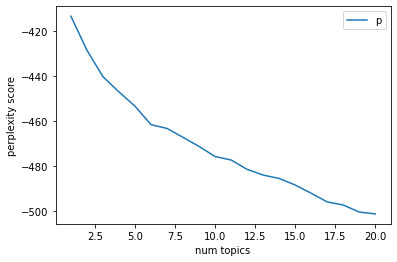

In [15]:
x_list = []
y_list = []
for i in range(1,21):
    lm = LoadModel(i)
    dct = Dictionary(corpus)
    data = [dct.doc2bow(_) for _ in corpus]
    perplexity = lm.ldamodel.log_perplexity(data)
    print(perplexity)
    x_list.append(i)
    y_list.append(perplexity)
plt.plot(x_list, y_list)
plt.xlabel('num topics')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')
plt.show()    

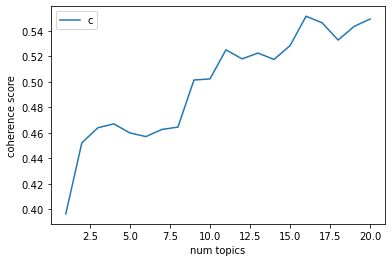

In [16]:
x1_list = []
y1_list = []
for i in range(1,21):
    lm = LoadModel(i)
    dct = Dictionary(corpus)
    data = [dct.doc2bow(_) for _ in corpus]
    cv_tmp = CoherenceModel(model=lm.ldamodel, texts=corpus, dictionary=dct, coherence='c_v')
    x1_list.append(i)
    y1_list.append(cv_tmp.get_coherence())
plt.plot(x1_list, y1_list)
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()    

In [18]:
for i in range(4,21):
    cor(i,corpus,df_temp_contain1,df_temp_contain1)

==============4===============
(0, '0.006*"生态" + 0.006*"规划" + 0.005*"经济" + 0.005*"实施" + 0.005*"改革" + 0.005*"重点" + 0.005*"社会" + 0.004*"环保" + 0.004*"环境" + 0.004*"全国" + 0.004*"管理" + 0.004*"制度" + 0.004*"生态文明" + 0.003*"目标" + 0.003*"区域" + 0.003*"创新" + 0.003*"市" + 0.003*"体系" + 0.003*"政府" + 0.003*"机制" + 0.003*"服务" + 0.003*"完善" + 0.003*"建立" + 0.003*"民生" + 0.003*"落实" + 0.003*"进一步" + 0.003*"建成" + 0.003*"农村" + 0.003*"保障" + 0.002*"工程" + 0.002*"治理" + 0.002*"综合" + 0.002*"群众" + 0.002*"科普" + 0.002*"活动" + 0.002*"部门" + 0.002*"污染" + 0.002*"协调" + 0.002*"会议" + 0.002*"水平"')
(1, '0.010*"企业" + 0.008*"市场" + 0.007*"中国" + 0.007*"节能" + 0.006*"行业" + 0.006*"汽车" + 0.006*"技术" + 0.005*"建筑" + 0.005*"新能源" + 0.005*"能源" + 0.005*"标准" + 0.005*"产品" + 0.004*"低碳" + 0.004*"政策" + 0.004*"生产" + 0.003*"公司" + 0.003*"LED" + 0.003*"排放" + 0.003*"环保" + 0.003*"照明" + 0.003*"政府" + 0.003*"绿色建筑" + 0.003*"成本" + 0.003*"下降" + 0.003*"管理" + 0.003*"全国" + 0.002*"数据" + 0.002*"减少" + 0.002*"情况" + 0.002*"交易" + 0.002*"影响" + 0.002*"万吨" + 0.002*"消费" + 0.00

日期
2010-01-05    5
2010-01-05    5
2010-01-05    4
2010-01-12    3
2010-01-15    2
             ..
2017-12-26    3
2017-12-27    3
2017-12-28    5
2017-12-29    0
2017-12-29    4
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.078704  0.095823  0.125436  0.131024  0.193122  0.144762  0.126354   
1      0.181713  0.162162  0.171893  0.201807  0.198413  0.121905  0.093863   
2      0.123843  0.124079  0.106852  0.099398  0.082011  0.078095  0.095668   
3      0.243056  0.248157  0.186992  0.188253  0.164021  0.323810  0.359206   
4      0.194444  0.178133  0.139373  0.146084  0.100529  0.139048  0.129964   
5      0.178241  0.191646  0.269454  0.233434  0.261905  0.192381  0.194946   

日期         2017  
topic  

日期
2010-01-05    6
2010-01-05    6
2010-01-05    4
2010-01-12    3
2010-01-15    2
             ..
2017-12-26    5
2017-12-27    3
2017-12-28    3
2017-12-29    0
2017-12-29    4
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.096065  0.083538  0.084785  0.096386  0.126984  0.112381  0.090253   
1      0.114583  0.110565  0.104530  0.102410  0.116402  0.059048  0.050542   
2      0.065972  0.099509  0.102207  0.146084  0.129630  0.080000  0.102888   
3      0.188657  0.216216  0.139373  0.126506  0.105820  0.232381  0.276173   
4      0.190972  0.124079  0.096400  0.090361  0.079365  0.085714  0.066787   
5      0.145833  0.135135  0.164925  0.125000  0.179894  0.133333  0.113718   
6      0.133102  0.163391 

日期
2010-01-05    6
2010-01-05    6
2010-01-05    4
2010-01-12    3
2010-01-15    2
             ..
2017-12-26    5
2017-12-27    3
2017-12-28    3
2017-12-29    0
2017-12-29    4
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.071759  0.085995  0.092915  0.079819  0.156085  0.116190  0.090253   
1      0.083333  0.082310  0.075494  0.085843  0.111111  0.045714  0.037906   
2      0.070602  0.087224  0.082462  0.076807  0.060847  0.053333  0.077617   
3      0.160880  0.176904  0.121951  0.108434  0.087302  0.163810  0.214801   
4      0.148148  0.097052  0.073171  0.052711  0.047619  0.068571  0.045126   
5      0.143519  0.119165  0.164925  0.106928  0.161376  0.106667  0.092058   
6      0.114583  0.138821 

(0, '0.013*"环保" + 0.008*"企业" + 0.008*"实施" + 0.007*"环境" + 0.006*"管理" + 0.006*"污染" + 0.006*"重点" + 0.006*"政府" + 0.005*"市" + 0.005*"整治" + 0.005*"部门" + 0.005*"制度" + 0.005*"治理" + 0.004*"标准" + 0.004*"情况" + 0.004*"考核" + 0.004*"建立" + 0.004*"亿元" + 0.004*"资金" + 0.004*"单位" + 0.004*"目标" + 0.003*"厅" + 0.003*"全国" + 0.003*"减排" + 0.003*"方案" + 0.003*"落实" + 0.003*"监管" + 0.003*"试点" + 0.003*"责任" + 0.003*"环境保护" + 0.003*"指标" + 0.003*"审批" + 0.003*"广州市" + 0.003*"意见" + 0.003*"财政" + 0.003*"设施" + 0.003*"林业" + 0.003*"生态" + 0.003*"万元" + 0.003*"出台"')
(1, '0.018*"能源" + 0.016*"低碳" + 0.013*"企业" + 0.009*"中国" + 0.008*"电网" + 0.007*"LED" + 0.007*"照明" + 0.007*"交易" + 0.007*"碳排放" + 0.007*"配额" + 0.007*"排放" + 0.006*"节能" + 0.006*"发电" + 0.006*"减排" + 0.006*"全国" + 0.005*"市场" + 0.005*"核电" + 0.005*"技术" + 0.005*"电力" + 0.005*"试点" + 0.005*"太阳能" + 0.005*"二氧化碳" + 0.005*"万吨" + 0.005*"光伏" + 0.004*"气候变化" + 0.004*"清洁" + 0.004*"全球" + 0.004*"节能减排" + 0.004*"行业" + 0.004*"碳交易" + 0.004*"目标" + 0.004*"供电" + 0.004*"碳排放权" + 0.004*"碳市场" + 0.004*"研究" + 0

(0, '0.013*"环保" + 0.010*"企业" + 0.008*"实施" + 0.007*"管理" + 0.007*"环境" + 0.007*"政府" + 0.006*"重点" + 0.006*"污染" + 0.006*"市" + 0.006*"制度" + 0.005*"部门" + 0.005*"整治" + 0.005*"治理" + 0.005*"标准" + 0.004*"建立" + 0.004*"情况" + 0.004*"考核" + 0.004*"单位" + 0.004*"资金" + 0.004*"落实" + 0.004*"责任" + 0.004*"目标" + 0.004*"意见" + 0.003*"监管" + 0.003*"试点" + 0.003*"社会" + 0.003*"厅" + 0.003*"全国" + 0.003*"审批" + 0.003*"方案" + 0.003*"财政" + 0.003*"环境保护" + 0.003*"机制" + 0.003*"减排" + 0.003*"广州市" + 0.003*"制定" + 0.003*"出台" + 0.003*"省政府" + 0.003*"指标" + 0.003*"政策"')
(1, '0.020*"能源" + 0.018*"低碳" + 0.014*"企业" + 0.011*"中国" + 0.008*"电网" + 0.008*"交易" + 0.007*"碳排放" + 0.007*"配额" + 0.007*"排放" + 0.006*"发电" + 0.006*"减排" + 0.006*"试点" + 0.006*"全国" + 0.006*"万吨" + 0.006*"核电" + 0.005*"市场" + 0.005*"太阳能" + 0.005*"电力" + 0.005*"二氧化碳" + 0.005*"光伏" + 0.005*"技术" + 0.005*"清洁" + 0.005*"气候变化" + 0.004*"全球" + 0.004*"节能" + 0.004*"目标" + 0.004*"节能减排" + 0.004*"碳交易" + 0.004*"碳排放权" + 0.004*"行业" + 0.004*"碳市场" + 0.004*"发改委" + 0.004*"欧盟" + 0.003*"研究" + 0.003*"减少" + 

(0, '0.013*"企业" + 0.011*"环保" + 0.008*"实施" + 0.008*"管理" + 0.007*"政府" + 0.007*"重点" + 0.006*"环境" + 0.006*"部门" + 0.006*"市" + 0.005*"制度" + 0.005*"标准" + 0.005*"整治" + 0.005*"资金" + 0.005*"建立" + 0.005*"污染" + 0.004*"情况" + 0.004*"亿元" + 0.004*"单位" + 0.004*"治理" + 0.004*"服务" + 0.004*"广州市" + 0.004*"考核" + 0.004*"意见" + 0.004*"责任" + 0.004*"厅" + 0.004*"财政" + 0.004*"审批" + 0.004*"落实" + 0.004*"社会" + 0.004*"监管" + 0.004*"万元" + 0.003*"出台" + 0.003*"政策" + 0.003*"方案" + 0.003*"全国" + 0.003*"支持" + 0.003*"试点" + 0.003*"机制" + 0.003*"制定" + 0.003*"项"')
(1, '0.018*"能源" + 0.018*"LED" + 0.018*"企业" + 0.018*"低碳" + 0.014*"照明" + 0.013*"节能" + 0.009*"交易" + 0.009*"电网" + 0.008*"配额" + 0.008*"碳排放" + 0.007*"市场" + 0.007*"全国" + 0.007*"试点" + 0.006*"行业" + 0.006*"电力" + 0.006*"发电" + 0.006*"太阳能" + 0.006*"核电" + 0.006*"万吨" + 0.006*"节能减排" + 0.006*"光伏" + 0.005*"排放" + 0.005*"技术" + 0.005*"减排" + 0.005*"供电" + 0.005*"碳交易" + 0.004*"碳排放权" + 0.004*"十二五" + 0.004*"目标" + 0.004*"碳市场" + 0.004*"改造" + 0.004*"能耗" + 0.004*"清洁" + 0.004*"产品" + 0.004*"用电" + 0.004*"

(0, '0.018*"企业" + 0.017*"环保" + 0.008*"重点" + 0.008*"实施" + 0.008*"亿元" + 0.008*"环境" + 0.007*"全国" + 0.006*"污染" + 0.006*"资金" + 0.006*"整治" + 0.006*"万元" + 0.005*"科技" + 0.005*"支持" + 0.005*"创新" + 0.005*"工程" + 0.005*"市" + 0.005*"投入" + 0.005*"治理" + 0.004*"厅" + 0.004*"减排" + 0.004*"建立" + 0.004*"项" + 0.004*"试点" + 0.004*"标准" + 0.004*"农村" + 0.004*"考核" + 0.004*"知识产权" + 0.004*"水质" + 0.004*"综合" + 0.004*"广州市" + 0.004*"政府" + 0.003*"目标" + 0.003*"环境保护" + 0.003*"奖励" + 0.003*"省级" + 0.003*"基金" + 0.003*"污水处理" + 0.003*"新增" + 0.003*"省政府" + 0.003*"防治"')
(1, '0.021*"能源" + 0.019*"低碳" + 0.017*"企业" + 0.011*"交易" + 0.011*"节能" + 0.010*"电网" + 0.009*"配额" + 0.009*"碳排放" + 0.008*"万吨" + 0.007*"试点" + 0.007*"发电" + 0.007*"电力" + 0.007*"全国" + 0.007*"核电" + 0.007*"排放" + 0.006*"太阳能" + 0.006*"光伏" + 0.006*"市场" + 0.006*"节能减排" + 0.006*"行业" + 0.005*"供电" + 0.005*"减排" + 0.005*"碳交易" + 0.005*"碳排放权" + 0.005*"清洁" + 0.005*"目标" + 0.005*"水泥" + 0.005*"二氧化碳" + 0.005*"碳市场" + 0.005*"新能源" + 0.004*"用电" + 0.004*"发改委" + 0.004*"能耗" + 0.004*"十二五" + 0.004*"技术"

(0, '0.019*"环保" + 0.011*"环境" + 0.010*"森林" + 0.009*"生态" + 0.009*"整治" + 0.009*"重点" + 0.007*"企业" + 0.007*"污染" + 0.007*"实施" + 0.006*"全国" + 0.006*"市" + 0.006*"治理" + 0.006*"林业" + 0.006*"考核" + 0.005*"工程" + 0.005*"厅" + 0.005*"水质" + 0.005*"环境保护" + 0.005*"亿元" + 0.005*"目标" + 0.004*"农村" + 0.004*"减排" + 0.004*"绿化" + 0.004*"水" + 0.004*"投入" + 0.004*"万元" + 0.004*"资金" + 0.004*"防治" + 0.004*"综合" + 0.004*"污水处理" + 0.003*"保护" + 0.003*"设施" + 0.003*"指标" + 0.003*"省政府" + 0.003*"达标" + 0.003*"类" + 0.003*"空气质量" + 0.003*"流域" + 0.003*"方案" + 0.003*"年度"')
(1, '0.021*"能源" + 0.020*"低碳" + 0.018*"企业" + 0.014*"节能" + 0.012*"交易" + 0.010*"电网" + 0.009*"试点" + 0.009*"配额" + 0.008*"碳排放" + 0.007*"全国" + 0.007*"发电" + 0.007*"电力" + 0.007*"万吨" + 0.007*"核电" + 0.006*"节能减排" + 0.006*"市场" + 0.006*"光伏" + 0.006*"太阳能" + 0.006*"排放" + 0.006*"行业" + 0.005*"供电" + 0.005*"减排" + 0.005*"清洁" + 0.005*"碳交易" + 0.005*"碳排放权" + 0.005*"目标" + 0.005*"技术" + 0.005*"LED" + 0.005*"照明" + 0.005*"水泥" + 0.005*"能耗" + 0.004*"碳市场" + 0.004*"二氧化碳" + 0.004*"十二五" + 0.004*"发改委" +

日期
2010-01-05    11
2010-01-05    10
2010-01-05    13
2010-01-12     3
2010-01-15    13
              ..
2017-12-26     5
2017-12-27     3
2017-12-28    15
2017-12-29    13
2017-12-29    10
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.035880  0.047912  0.049942  0.037651  0.084656  0.072381  0.068592   
1      0.070602  0.065111  0.055749  0.067771  0.089947  0.043810  0.034296   
2      0.047454  0.051597  0.031359  0.043675  0.044974  0.030476  0.061372   
3      0.129630  0.147420  0.091754  0.081325  0.079365  0.127619  0.148014   
4      0.034722  0.034398  0.024390  0.040663  0.015873  0.019048  0.025271   
5      0.114583  0.085995  0.124274  0.094880  0.124339  0.108571  0.079422   
6      0.070602

日期
2010-01-05    11
2010-01-05     6
2010-01-05    13
2010-01-12     3
2010-01-15    13
              ..
2017-12-26     5
2017-12-27     3
2017-12-28     3
2017-12-29     0
2017-12-29    10
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.039352  0.039312  0.039489  0.048193  0.074074  0.070476  0.068592   
1      0.046296  0.057740  0.034843  0.057229  0.084656  0.040000  0.028881   
2      0.049769  0.052826  0.025552  0.042169  0.037037  0.030476  0.054152   
3      0.135417  0.153563  0.096400  0.072289  0.082011  0.114286  0.157040   
4      0.035880  0.028256  0.024390  0.037651  0.013228  0.022857  0.025271   
5      0.104167  0.081081  0.108014  0.093373  0.111111  0.110476  0.072202   
6      0.045139

日期
2010-01-05    11
2010-01-05     5
2010-01-05    10
2010-01-12    12
2010-01-15    13
              ..
2017-12-26     5
2017-12-27     3
2017-12-28    15
2017-12-29    13
2017-12-29    10
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.046296  0.055283  0.026713  0.031627  0.071429  0.047619  0.055957   
1      0.024306  0.035627  0.026713  0.051205  0.063492  0.032381  0.019856   
2      0.053241  0.049140  0.030197  0.043675  0.050265  0.026667  0.052347   
3      0.134259  0.141278  0.092915  0.069277  0.055556  0.116190  0.158845   
4      0.035880  0.029484  0.022067  0.045181  0.015873  0.028571  0.027076   
5      0.127315  0.089681  0.137050  0.094880  0.142857  0.108571  0.072202   
6      0.039352

日期
2010-01-05    10
2010-01-05    13
2010-01-05    10
2010-01-12     3
2010-01-15    13
              ..
2017-12-26     5
2017-12-27     3
2017-12-28    15
2017-12-29     0
2017-12-29    10
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.035880  0.050369  0.049942  0.061747  0.087302  0.078095  0.074007   
1      0.050926  0.058968  0.038328  0.060241  0.095238  0.036190  0.030686   
2      0.070602  0.060197  0.029036  0.039157  0.034392  0.020952  0.032491   
3      0.114583  0.116708  0.081301  0.067771  0.068783  0.120000  0.158845   
4      0.033565  0.031941  0.022067  0.040663  0.015873  0.024762  0.023466   
5      0.082176  0.070025  0.112660  0.073795  0.124339  0.093333  0.077617   
6      0.033565

日期
2010-01-05     6
2010-01-05     5
2010-01-05    13
2010-01-12     9
2010-01-15    13
              ..
2017-12-26     5
2017-12-27     3
2017-12-28    15
2017-12-29     0
2017-12-29    10
Name: topic, Length: 5081, dtype: int32
日期
2010    864
2011    814
2012    861
2013    664
2014    378
2015    525
2016    554
2017    421
Name: cut, dtype: int64
日期         2010      2011      2012      2013      2014      2015      2016  \
topic                                                                         
0      0.032407  0.040541  0.037166  0.030120  0.066138  0.053333  0.054152   
1      0.043981  0.046683  0.042973  0.058735  0.089947  0.038095  0.023466   
2      0.050926  0.050369  0.013937  0.025602  0.023810  0.009524  0.025271   
3      0.090278  0.111794  0.069686  0.046687  0.050265  0.100952  0.119134   
4      0.032407  0.028256  0.020906  0.036145  0.010582  0.022857  0.027076   
5      0.141204  0.090909  0.123113  0.085843  0.105820  0.076190  0.043321   
6      0.032407

In [ ]:
print("haha")